<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Huberlin-logo.svg/200px-Huberlin-logo.svg.png" alt="fff" align="left" style="width: 150px;width: 150px;align:left">


# Recurrent Encoder-Decoder Model (RED)
 
#### Thesis: Neural response generation for email conversations
#### Author: Sydney Richards
#### Required Runtime: GPU
#### Tensorflow version required 2.x






This notebook restores the previously trained RED models for either the English or the German data set. Note that it is not possible to restore both models within the same session. Also, it might be necessary to adjusted the paths of file imports, e.g. for the tokenizer or saved GLOVE embeddings. Ideally, users can quickly restore the models presented in the thesis in order to interact with them to familiarize themselves with the set up.



###Contents:

##### [1.System Set Up & File Import](#setup)
##### [2.Build RED Model](#build)
##### [3.Restore Checkpoints](#check)
##### [4.Generate Responses](#gen)
 - [English](#eng)
 - [German](#ger)



## 1. System Set Up & File Import
<a id='setup'></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
#import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import datetime as dt
import pandas as pd


seed = np.random.RandomState(seed=10)

In [2]:
!pip install nltk --upgrade

     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 1.5MB 2.8MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449908 sha256=83dc6d786d3c4765a4a6187a25da6ccbc98364689275cb8743753353ae9798a0
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [4]:
import nltk

#!wget 'https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip'
#!unzip stanford-corenlp-full-2018-10-05

nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [11]:
os.getcwd()

'/content'

In [0]:
MAX_LENGTH = 50 

In [0]:
with open("/content/drive/My Drive/Master Thesis/input_tokenizer.txt", "r") as text_file:
  data = text_file.readline()
input_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

with open("/content/drive/My Drive/Master Thesis/target_tokenizer.txt", "r") as text_file:
  data = text_file.readline()
target_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)


with open("/content/drive/My Drive/Master Thesis/input_tokenizer_DE.txt", "r") as text_file:
  data = text_file.readline()
input_tokenizerDE = tf.keras.preprocessing.text.tokenizer_from_json(data)

with open("/content/drive/My Drive/Master Thesis/target_tokenizer_DE.txt", "r") as text_file:
  data = text_file.readline()
target_tokenizerDE = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [0]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [0]:
BATCH_SIZE = 64
embedding_dim = 256
units = 1024
vocab_inp_size = len(input_tokenizer.word_index)+1
vocab_tar_size = len(target_tokenizer.word_index)+1

In [0]:
embeddings_matrixGlove = np.load('/content/drive/My Drive/Master Thesis/embedding.npy')

In [0]:
embeddings_matrixGloveDE = np.load('/content/drive/My Drive/Master Thesis/embeddingDE.npy')

## 2. Build RED model
<a id='build'></a>

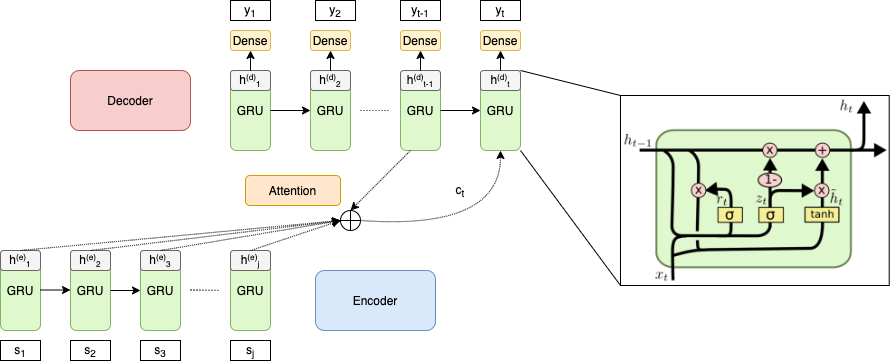

In [12]:
from IPython.display import Image
Image('/content/drive/My Drive/Master Thesis/Submission/Notebooks/figures/figure1A.png')

At a very high level a seq2seq model is made up of an encoder which reads an input and returns a "thought" vector that captures the meaning of the input. Secondly, the framework contains a decoder which uses this vector to produce an output sequence. Due to the fixed length nature of the of this vector the encoder might not be able to compress all available information into the context vector, especially for longer input sequences. Typically, an attention mechanism as introduced by [Bahadanu et al (2015)](https://arxiv.org/pdf/1409.0473.pdf) which uses a feed-forward neural network to attend the current decoder hidden state to each encoder hidden state is used. However, this thesis implements the simpler multiplicative version of attention implemented by [Luong et al (2015)](https://arxiv.org/abs/1508.04025v5)

### Encoder

In [0]:
class Encoder(tf.keras.Model):
  ### Output Shape (batch size, sequence length, #hidden units)
  ### Hidden State (batch size, #hidden units)
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim
                                               ,embeddings_initializer=
                                               tf.keras.initializers.Constant(embeddings_matrixGlove))
    self.gru1 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   go_backwards = True,
                                   recurrent_dropout = 0.2)
    
    self.gru2 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   go_backwards = False,
                                    recurrent_dropout = 0.2)

  def call(self, x, hidden):
    x = self.embedding(x)
    x, state = self.gru1(x, initial_state = hidden)
    output, state = self.gru2(x, initial_state = state)

    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class EncoderDE(tf.keras.Model):
  ### Output Shape (batch size, sequence length, #hidden units)
  ### Hidden State (batch size, #hidden units)
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(EncoderDE, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim
                                               ,embeddings_initializer=
                                               tf.keras.initializers.Constant(embeddings_matrixGloveDE))
    self.gru1 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   go_backwards = True,
                                   recurrent_dropout = 0.2)
    
    self.gru2 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   go_backwards = False,
                                    recurrent_dropout = 0.2)

  def call(self, x, hidden):
    x = self.embedding(x)
    x, state = self.gru1(x, initial_state = hidden)
    output, state = self.gru2(x, initial_state = state)

    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

### Attention

In [0]:
class DotAttention(tf.keras.layers.Layer):
  def __init__(self):
    super(DotAttention, self).__init__()

  def call(self, query, keys , values):
    #query: hidden_state
    #keys: encoder_output
    #values: encoder_output

    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = tf.matmul(query_with_time_axis, keys, transpose_b=True)

    score = tf.transpose(score,perm=[0,2,1])
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = DotAttention()

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output,enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [0]:
with mirrored_strategy.scope(): 
  encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

  decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

  #encoderDE = EncoderDE(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

  #decoderDE = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)



## 3. Restore Checkpoints
<a id='check'></a>

In [0]:
with mirrored_strategy.scope():
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  checkpoint_dir = '/content/drive/My Drive/Master Thesis/Checkpoints/training_checkpoints_seq2seq2'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                  encoder=encoder,
                                  decoder=decoder)


  ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

  # if a checkpoint exists, restore the latest checkpoint.
  if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print ('Recurrent Encoder-Decoder restored!!')

Recurrent Encoder-Decoder restored!!


In [0]:
with mirrored_strategy.scope():
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  checkpoint_dirDE = '/content/drive/My Drive/Master Thesis/Checkpoints/training_checkpoints_seq2seq2DE2'
  checkpoint_prefix = os.path.join(checkpoint_dirDE, "ckpt")
  checkpointDE = tf.train.Checkpoint(optimizer=optimizer,
                                  encoderDE=encoderDE,
                                  decoderDE=decoderDE)


  ckpt_managerDE = tf.train.CheckpointManager(checkpointDE, checkpoint_dirDE, max_to_keep=5)

  # if a checkpoint exists, restore the latest checkpoint.
  if ckpt_managerDE.latest_checkpoint:
    checkpointDE.restore(ckpt_managerDE.latest_checkpoint)
    print ('German Recurrent Encoder-Decoder restored!!')

German Recurrent Encoder-Decoder restored!!


## Inference

In [0]:
  def preprocess_sentence(w,is_input=False):
      #w = unicode_to_ascii(w.lower().strip())

      # creating a space between a word and the punctuation following it
      # eg: "he is a boy." => "he is a boy ."
      # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
      w = w.lower().strip()
      w = re.sub(r"([?.!,¿])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)
      w = w.replace('\n', ' ').replace('\r', ' ').replace('\xa0',' ')
      if is_input == True:
      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,0-9]+", " ", w)
      w = w.replace('car2go','<company>')
      w = w.replace('Share Now','<company>')

      w = w.rstrip().strip()

      # adding a start and an end token to the sentence
      # so that the model know when to start and stop predicting.
      w = '<start> ' + w + ' <end>'
      return w

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((MAX_LENGTH, MAX_LENGTH))

    sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=MAX_LENGTH,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)

    for t in range(MAX_LENGTH):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention.transpose(), cmap='Blues')

    fontdict = {'fontsize': 14}

    ax.set_yticklabels([''] + sentence, fontdict=fontdict)
    ax.set_xticklabels([''] + predicted_sentence, fontdict=fontdict, rotation=90)
    
    ax.set_ylabel('Input sequence')
    ax.set_xlabel('Output sequence')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    #plt.savefig('/content/drive/My Drive/Master Thesis/seq2seqAtn.png')
    plt.show()

In [0]:
def respond(sentence,plot=''):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('\nPredicted responses: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    if plot:
      plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Some enquiry suggestion which are typical for the domain:

- Please cancel my account and remove all credit card information from your system.
- Please see attached copy of my drivers license for my Car2Go records.
- Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.
- Car rental today - vehicle had warning light on that tire sensor was not working
- Hello, do you have a lost and found for items left in cars? I lost a scarf and Cab which are quite sentimental to me.
- Why am I not able to end my rental?

In [0]:
respond('Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.')

Input: <start> hi there , please find my proof of refuel purchase along with the <company> rental it applies to below . <end>

Predicted responses: we appreciate you taking the time to refuel our vehicle and thank you for submitting the receipt for the refueling ! we have refunded you the cost of your refuel <amt> you can expect to see reflected on your credit card statement in the next few business days <end> 


In [0]:
def evalauiere(sentence):
    attention_plot = np.zeros((MAX_LENGTH, MAX_LENGTH))

    sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizerDE.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=MAX_LENGTH,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoderDE(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizerDE.word_index['<start>']], 0)

    for t in range(MAX_LENGTH):
        predictions, dec_hidden, attention_weights = decoderDE(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizerDE.index_word[predicted_id] + ' '

        if target_tokenizerDE.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
def beantworte(sentence,plot=''):
    result, sentence, attention_plot = evalauiere(sentence)

    print('Input: %s' % (sentence))
    print('\nPredicted responses: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    if plot:
      plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Hallo, hiermit widerrufe ich meine Mitgliedschaft.

In [0]:
beantworte('Anbei sende ich einen Tankbeleg bitte erstattet mir den Betrag')


In [0]:
embeddings_matrixGlove = np.load('/content/drive/My Drive/Master Thesis/embeddingDE.npy')